# Importing necessary libraries

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [136]:
import warnings
warnings.filterwarnings('ignore')

# Loading legal test classification data

In [144]:
import os
project_path = os.getcwd()
file_path = project_path + "/legal_text_classification.csv"
data = pd.read_csv(file_path)

data.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


# Data pre-processing

## Dataset information

In [103]:
print("Dataset information")
data.info()

Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24985 non-null  object
 1   case_outcome  24985 non-null  object
 2   case_title    24985 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 780.9+ KB


## Shape of the dataset

In [105]:
print("Shape of the dataset")
data.shape

Shape of the dataset


(24985, 4)

## Checking for missing values

In [107]:
print("Checking for missing values")
data.isnull().sum()

Checking for missing values


case_id           0
case_outcome      0
case_title        0
case_text       176
dtype: int64

## Missing values after replacement

In [109]:
# Replaceing missing text with a placeholder
data['case_text'].fillna("missing text", inplace=True)

print("Missing values after replacement:")
print(data.isnull().sum())

Missing values after replacement:
case_id         0
case_outcome    0
case_title      0
case_text       0
dtype: int64


# Exploratory data analysis (EDA)

## Descriptive statistics

In [112]:
print("Descriptive statistics")
data.describe()

Descriptive statistics


,case_id,case_outcome,case_title,case_text
count,24985,24985,24985,24985
unique,24985,10,18581,17921
top,Case1,cited,Minister for Immigration and Ethnic Affairs v ...,missing text
freq,1,12219,70,176


## Distribution of Case Outcomes

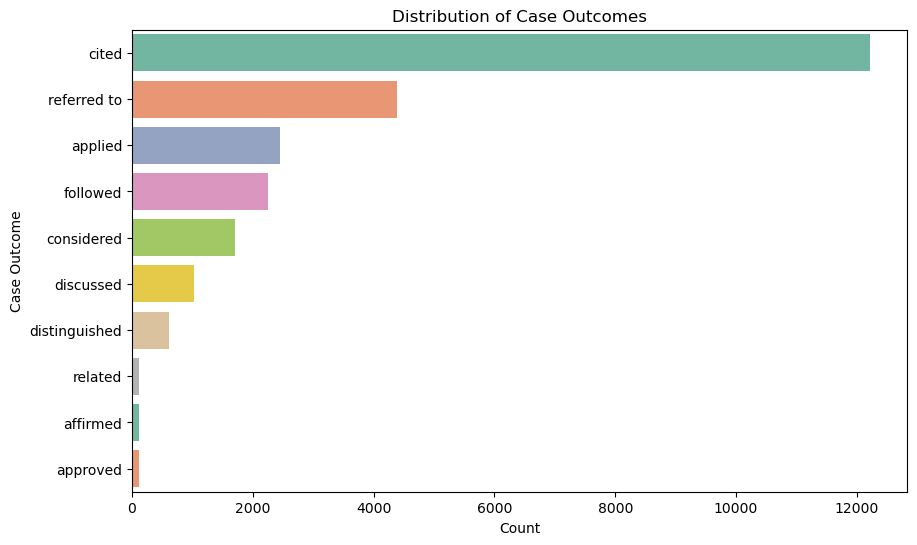

In [114]:
plt.figure(figsize=(10,6))
sns.countplot(y='case_outcome', data=data, order=data['case_outcome'].value_counts().index, palette="Set2")
plt.title("Distribution of Case Outcomes")
plt.xlabel("Count")
plt.ylabel("Case Outcome")
plt.show()

## Word Cloud from Case Text

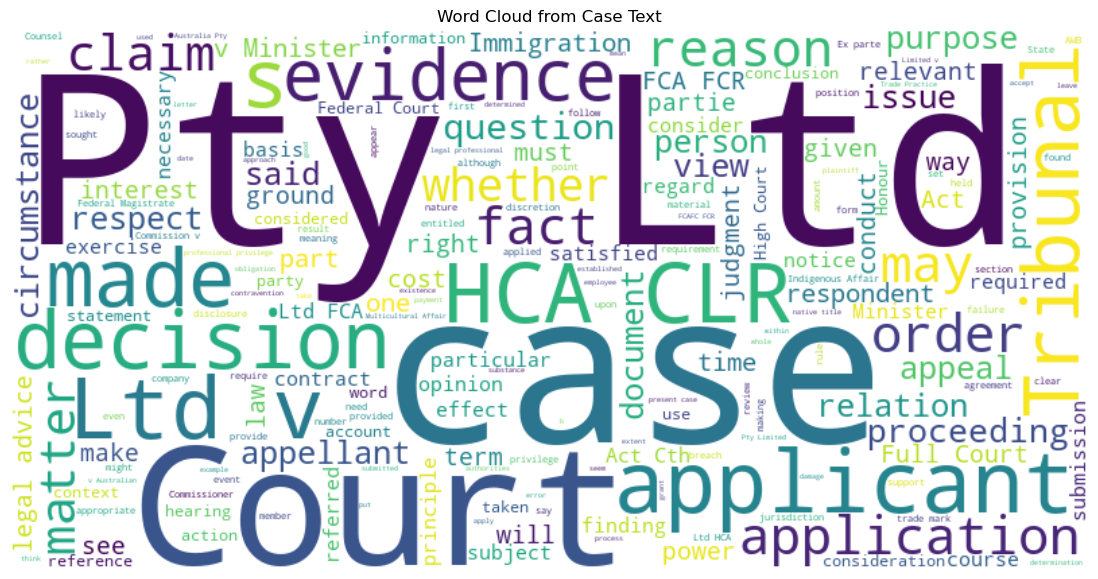

In [116]:
text = ' '.join(data['case_text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud from Case Text")
plt.show()

## Top 20 Most Frequent Words

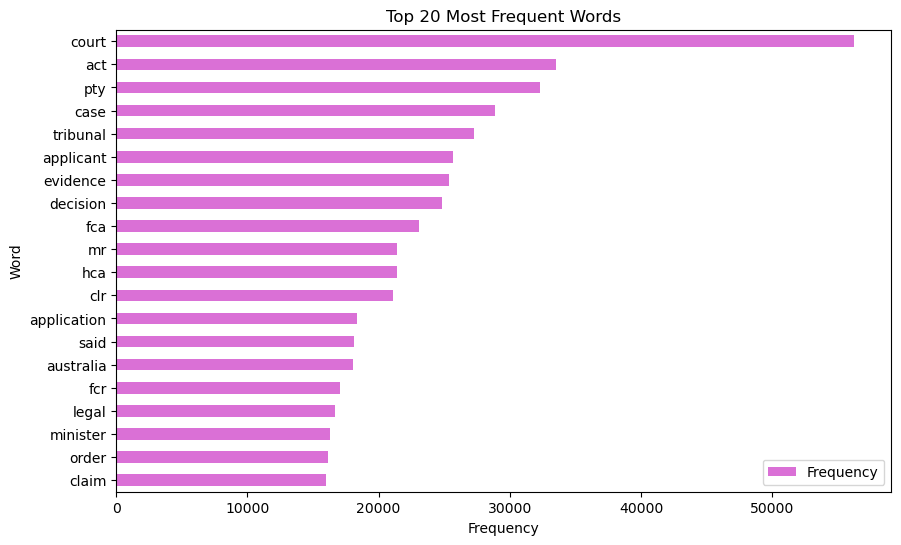

In [118]:
cv = CountVectorizer(stop_words='english', max_features=20)
X = cv.fit_transform(data['case_text'].astype(str))
word_freq = X.sum(axis=0).A1
words = cv.get_feature_names_out()

word_freq_df = pd.DataFrame({'Word': words, 'Frequency': word_freq})
word_freq_df.sort_values(by='Frequency', ascending=True).plot.barh(x='Word', y='Frequency', figsize=(10,6), color="orchid")
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.show()


## Distribution of Document Length Categories

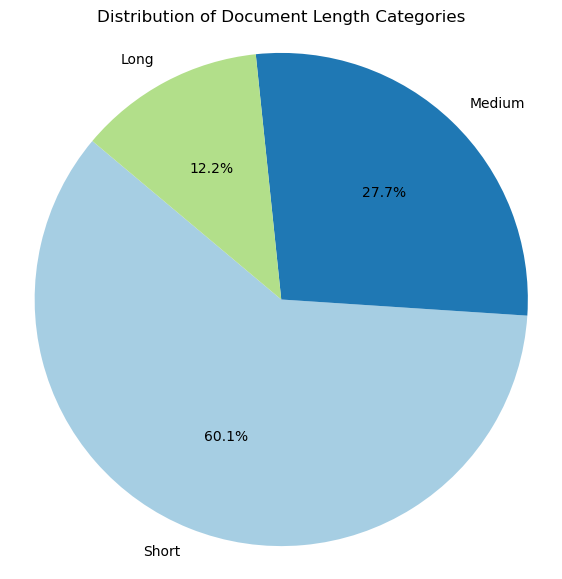

In [120]:
data['text_length'] = data['case_text'].apply(lambda x: len(str(x).split()))

# Creating bins
def length_category(length):
    if length < 300:
        return 'Short'
    elif length <= 700:
        return 'Medium'
    else:
        return 'Long'

# Applying categorization
data['length_category'] = data['text_length'].apply(length_category)

length_counts = data['length_category'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(length_counts, labels=length_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of Document Length Categories")
plt.axis('equal')
plt.show()


## Average Document Length per Case Outcome

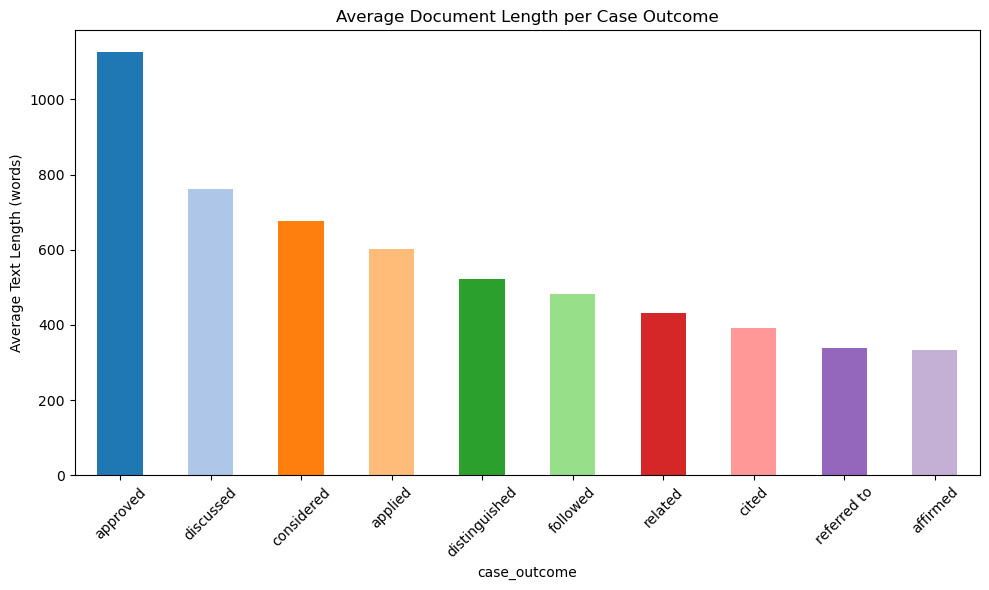

In [122]:
avg_length = data.groupby('case_outcome')['text_length'].mean().sort_values(ascending=False)

colors = plt.cm.tab20.colors[:len(avg_length)]

avg_length.plot(kind='bar', figsize=(10,6), color=colors)

plt.ylabel("Average Text Length (words)")
plt.title("Average Document Length per Case Outcome")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Model implementation

## Splitting and Vectorizing the text data using TF-IDF

In [125]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(data['case_text'].astype(str))
y = data['case_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Support Vector Machine (Linear SVC)


 Support Vector Machine Results:
Accuracy: 0.5701420852511507
Classification Report:
                precision    recall  f1-score   support

     affirmed       0.69      0.48      0.56        23
      applied       0.32      0.21      0.26       489
     approved       0.17      0.05      0.07        21
        cited       0.63      0.82      0.71      2444
   considered       0.45      0.27      0.33       342
    discussed       0.37      0.18      0.24       205
distinguished       0.48      0.25      0.33       122
     followed       0.45      0.28      0.35       451
  referred to       0.53      0.51      0.52       877
      related       0.40      0.09      0.14        23

     accuracy                           0.57      4997
    macro avg       0.45      0.31      0.35      4997
 weighted avg       0.54      0.57      0.54      4997



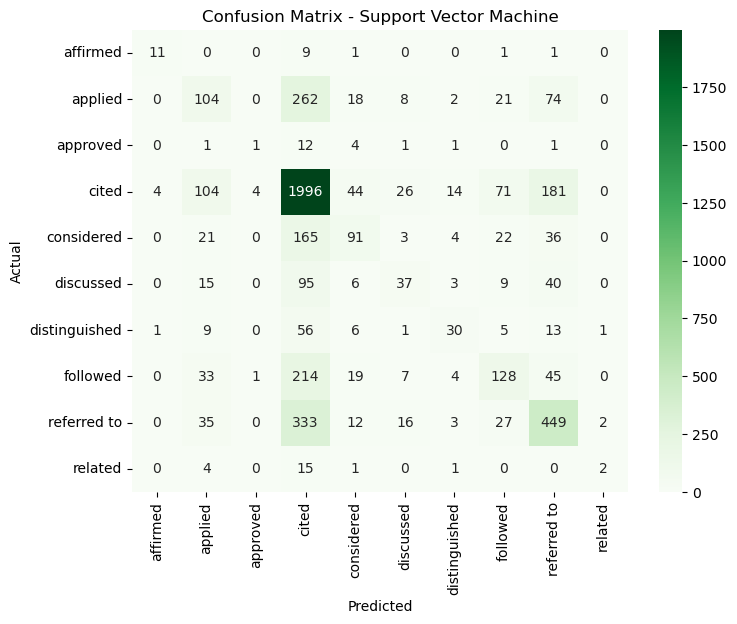

In [127]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

print("\n Support Vector Machine Results:")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print("Classification Report:\n", classification_report(y_test, svm_preds))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt='d', cmap='Greens',
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("Confusion Matrix - Support Vector Machine")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Random Forest


 Random Forest Results:
Accuracy: 0.5767460476285772
Classification Report:
                precision    recall  f1-score   support

     affirmed       0.75      0.13      0.22        23
      applied       0.49      0.16      0.24       489
     approved       0.20      0.05      0.08        21
        cited       0.56      0.94      0.70      2444
   considered       0.53      0.14      0.22       342
    discussed       0.40      0.05      0.09       205
distinguished       0.69      0.20      0.32       122
     followed       0.72      0.26      0.38       451
  referred to       0.76      0.35      0.48       877
      related       0.00      0.00      0.00        23

     accuracy                           0.58      4997
    macro avg       0.51      0.23      0.27      4997
 weighted avg       0.59      0.58      0.51      4997



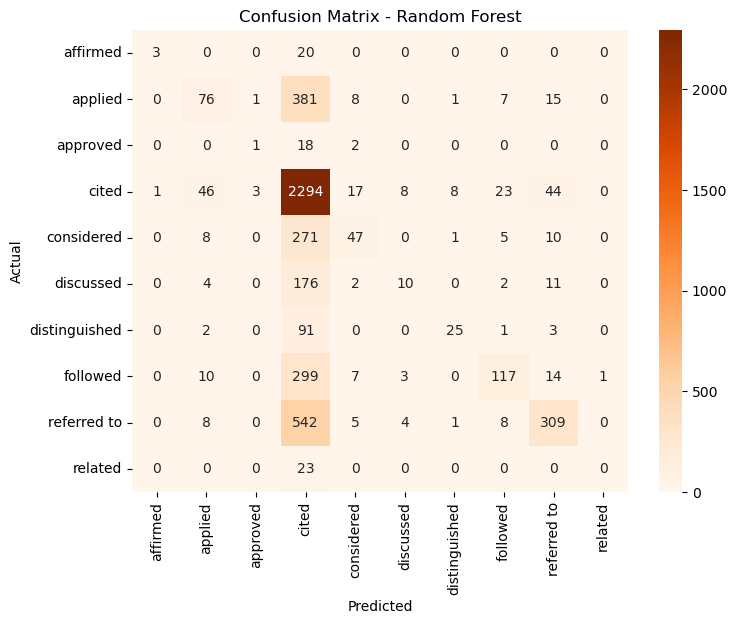

In [129]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("\n Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Oranges',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Model Accuracy Comparison

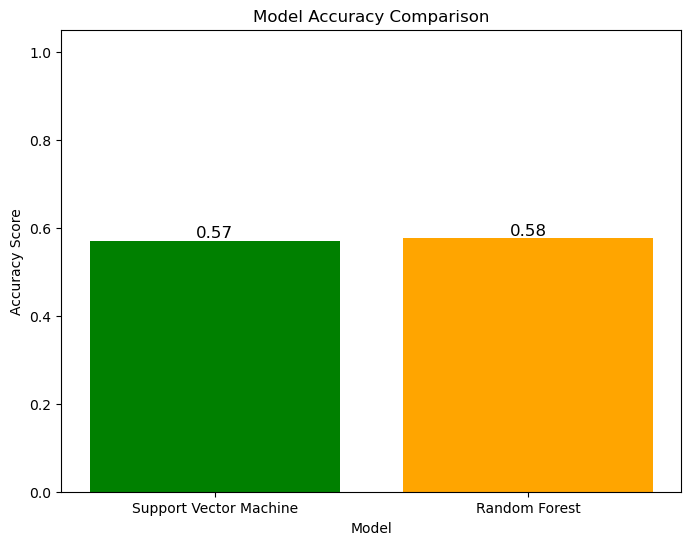

In [131]:
svm_accuracy = accuracy_score(y_test, svm_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

model_names = ['Support Vector Machine', 'Random Forest']
accuracies = [svm_accuracy, rf_accuracy]

plt.figure(figsize=(8,6))
bars = plt.bar(model_names, accuracies, color=['green', 'orange'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1.05)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.show()

## Text classification

In [133]:
texts = [
    "The appeal was allowed and the decision of the lower court was overturned.",
    "The case followed the precedent established by an earlier judgment."
]

text_vectors = vectorizer.transform(texts)
predictions = rf_model.predict(text_vectors)

for i, text in enumerate(texts):
    print(f"\nText: {text}")
    print("Predicted Case Outcome:", predictions[i])



Text: The appeal was allowed and the decision of the lower court was overturned.
Predicted Case Outcome: cited

Text: The case followed the precedent established by an earlier judgment.
Predicted Case Outcome: cited
